.

# Partie 2: Implémentation d'un clustering sur la partie des caractéristiques de notre jeu de donnée

### Objectif de cette étape
L’objectif ici est de standardiser les variables afin d’éviter qu’une variable avec de grandes valeurs
domine les autres lors de l’apprentissage du modèle.


## I. Détermination des hyperparamètres optimales 

In [83]:
X.shape

(569, 30)

In [ ]:
X.info()

Nous allons écrire une fonction pour déterminer k et eps

Même si nous savons que k=2, nous somme currieux de savoir lequel est identifié par la méthode de coude comme étant l'optimal

In [1]:
from sklearn.preprocessing import StandardScaler
def preprocess_data(df):
    X = df.drop(columns=["Label"])
    y = df["Label"]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y, scaler


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors

def find_k_and_eps(df, k_max=10, min_pts_ratio=2.5, sample_max=2000, display=True):

.
    X = StandardScaler().fit_transform(df.values)

    if len(X) > sample_max:
        idx = np.random.choice(len(X), sample_max, replace=False)
        X_sample = X[idx]
    else:
        X_sample = X

    inertias, silhouettes, davies_bouldin = [], [], []
    K_values = range(2, k_max + 1)

    #  Recherche du meilleur K pour KMeans
    for k in K_values:
        kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=2048)
        labels = kmeans.fit_predict(X_sample)

        inertias.append(kmeans.inertia_)
        silhouettes.append(silhouette_score(X_sample, labels))
        davies_bouldin.append(davies_bouldin_score(X_sample, labels))

    k_opt = K_values[int(np.argmax(silhouettes))] # Prends la valeur de K qui a donné le meilleur score silhouette

    #  Recherche de eps optimal pour DBSCAN
    minPts = int(df.shape[1] * min_pts_ratio)
    neigh = NearestNeighbors(n_neighbors=minPts, n_jobs=-1)
    nbrs = neigh.fit(X_sample)
    distances, _ = nbrs.kneighbors(X_sample)
    k_distances = np.sort(distances[:, -1])

    # Détection automatique du coude
    i = np.arange(len(k_distances))
    p1 = np.array([0, k_distances[0]])
    p2 = np.array([len(k_distances) - 1, k_distances[-1]])
    distance_to_line = np.abs(np.cross(p2 - p1, np.vstack((i, k_distances)).T - p1)) / np.linalg.norm(p2 - p1)
    eps_optimal = k_distances[np.argmax(distance_to_line)]

    #  Visualisation
    if display:
        plt.figure(figsize=(18, 5))

        plt.subplot(1, 3, 1)
        plt.plot(K_values, inertias, 'o-', label='Inertie')
        plt.axvline(k_opt, color='r', linestyle='--', label=f'K optimal = {k_opt}')
        plt.title("Méthode du coude (Inertie)")
        plt.xlabel("K")
        plt.ylabel("Inertie")
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(K_values, silhouettes, 'o-', color='green', label='Silhouette')
        plt.axvline(k_opt, color='r', linestyle='--')
        plt.title("Score Silhouette")
        plt.xlabel("K")
        plt.ylabel("Silhouette")
        plt.legend()

        plt.subplot(1, 3, 3)
        plt.plot(K_values, davies_bouldin, 'o-', color='orange', label='Davies-Bouldin')
        plt.axvline(k_opt, color='r', linestyle='--')
        plt.title("Indice Davies-Bouldin (plus petit = meilleur)")
        plt.xlabel("K")
        plt.ylabel("Score")
        plt.legend()

        plt.tight_layout()
        plt.show()

        # k-distance
        plt.figure(figsize=(6, 4))
        plt.plot(k_distances)
        plt.axhline(y=eps_optimal, color='r', linestyle='--', label=f"ε optimal = {eps_optimal:.4f}")
        plt.title(f"Courbe k-distance (minPts = {minPts})")
        plt.xlabel("Points triés")
        plt.ylabel(f"Distance au {minPts}ᵉ voisin")
        plt.legend()
        plt.grid(True)
        plt.show()

    # Affichage
    print(f" K optimal trouvé : {k_opt}")
    print(f" Epsilon optimal trouvé : {eps_optimal:.4f}")
    print(f" minPts utilisé : {minPts}")

    return k_opt, eps_optimal


C:\Users\MEHOUN MARTINIEN\AppData\Local\Temp\ipykernel_3788\2110152141.py:46: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  distance_to_line = np.abs(np.cross(p2 - p1, np.vstack((i, k_distances)).T - p1)) / np.linalg.norm(p2 - p1)


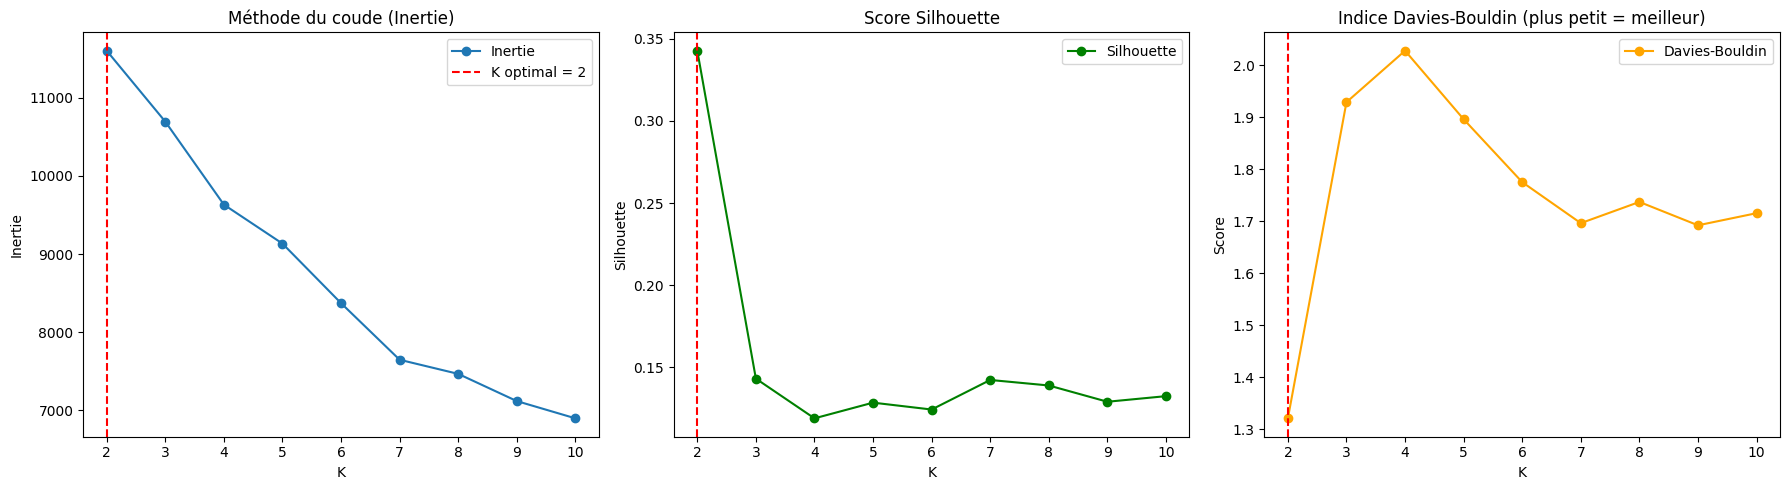

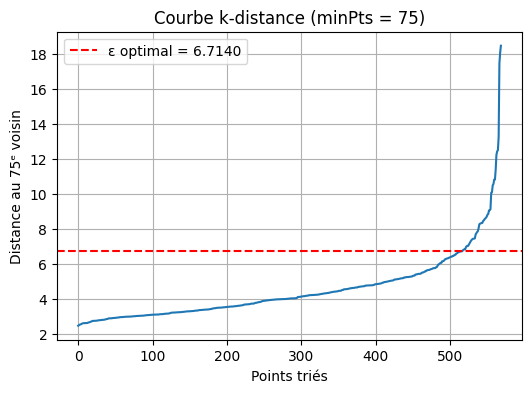

 K optimal trouvé : 2
 Epsilon optimal trouvé : 6.7140
 minPts utilisé : 75
K optimal = 2
Epsilon optimal = 6.714046275145607


In [81]:
k, eps = find_k_and_eps(X,sample_max=569)
print("K optimal =", k)
print("Epsilon optimal =", eps)

Interprétation des résultats :

Sur le graphique du score Silhouette, la valeur maximale semble se situer autour de k=2 (score d'environ 0.30-0.35), ce qui confirme que k=2 est optimal car un score plus proche de 1 indique de meilleurs clusters.

Pour l'indice Davies-Bouldin, la valeur minimale apparaît également vers k=2, ce qui est cohérent puisque pour cet indice, plus la valeur est faible, meilleure est la séparation entre les clusters.

Ainsi, les trois métriques convergent :

Méthode du coude : k=2

Score Silhouette maximal : k=2

Indice Davies-Bouldin minimal : k=2

Conclusion : k=2 est clairement le choix optimal.

Cependant, k=7 est un candidat potentiel.

Sur le graphique d'inertie (méthode du coude), on observe un premier coude marqué à k=2, mais un second coude subtil apparaît vers k=7, où la décroissance de l'inertie ralentit à nouveau.

Pour le score Silhouette, bien que le maximum absolu soit à k=2, la valeur pour k=7 reste relativement correcte (environ 0.15-0.20), ce qui n'est pas négligeable.

L'indice Davies-Bouldin montre également une valeur basse pour k=7, comparable à d'autres k intermédiaires.

k=7 pourrait donc être un bon compromis mais pour notre étude , le domaine métier ne justifie pas  une segmentation plus fine.

Nous allons garder k=2 pour la suite de l'analyse.



## II. Comparaison de plusieurs algorithme de clustering 

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans, DBSCAN, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
import hdbscan
from scipy.spatial.distance import pdist, squareform

# Dunn Index 
def dunn_index(X, labels, max_points=3000):
    if len(X) > max_points:
        idx = np.random.choice(len(X), max_points, replace=False)
        X = X[idx]
        labels = labels[idx]
    distances = squareform(pdist(X))
    clusters = np.unique(labels)
    clusters = [c for c in clusters if c != -1]
    if len(clusters) < 2:
        return 0
    intra = max([np.max(distances[labels == c][:, labels == c]) for c in clusters])
    inter = np.min([
        distances[np.ix_(labels == c1, labels == c2)].min()
        for i, c1 in enumerate(clusters) for c2 in clusters[i + 1:]
    ])
    return inter / intra

#Stabilité
def stability_score(X, labels_func, runs=3, ratio=0.3):
    scores = []
    n = len(X)
    m = int(ratio * n)
    for _ in range(runs):
        idx1 = np.random.choice(n, m, replace=False)
        idx2 = np.random.choice(n, m, replace=False)
        l1 = labels_func(X[idx1])
        l2 = labels_func(X[idx2])
        min_len = min(len(l1), len(l2))
        s = np.mean(l1[:min_len] == l2[:min_len])
        scores.append(s)
    return np.mean(scores)




In [11]:
from sklearn.metrics import f1_score

def clustering_compare_full(X,y, k=2, eps=0.5, minPts=10,
                            algos=["kmeans", "dbscan", "hdbscan", "spectral"],
                            pca_components=None):
    print(" Standardisation des données...")
    X = StandardScaler().fit_transform(df.values)
    y_true = y  

    # PCA facultative
    if pca_components is not None and pca_components < X.shape[1]:
        print(f"Réduction PCA à {pca_components} composantes...")
        X = PCA(n_components=pca_components, random_state=42).fit_transform(X)

    results = {}
    print(" Exécution des algorithmes sur tout le dataset...")

    # KMeans
    if "kmeans" in algos:
        print(" MiniBatchKMeans...")
        kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=4096).fit(X)
        labels = kmeans.labels_
        results["KMeans"] = {
            "CH": calinski_harabasz_score(X, labels),
            "Silhouette": silhouette_score(X, labels, sample_size=5000, random_state=42),
            "Dunn": dunn_index(X, labels),
            "Davies": davies_bouldin_score(X, labels),
            "Stability": stability_score(X, lambda data: MiniBatchKMeans(
                n_clusters=k, random_state=42, batch_size=4096).fit(data).labels_),
            "F1_macro": f1_score(y_true, labels, average="macro")  #
        }
        results["KMeans"]["labels"] = labels

    # DBSCAN
    if "dbscan" in algos:
        print(" DBSCAN...")
        dbs = DBSCAN(eps=eps, min_samples=minPts, n_jobs=-1).fit(X)
        labels = dbs.labels_
        if len(set(labels)) > 1:
            results["DBSCAN"] = {
                "CH": calinski_harabasz_score(X, labels),
                "Silhouette": silhouette_score(X, labels, sample_size=5000, random_state=42),
                "Dunn": dunn_index(X, labels),
                "Davies": davies_bouldin_score(X, labels),
                "Stability": stability_score(X, lambda data: DBSCAN(
                    eps=eps, min_samples=minPts, n_jobs=-1).fit(data).labels_),
                "F1_macro": f1_score(y_true, labels, average="macro")  # 
            }
        else:
            results["DBSCAN"] = {"CH": 0, "Silhouette": 0, "Dunn": 0,
                                 "Davies": float("inf"), "Stability": 0,
                                 "F1_macro": 0}
        results["DBSCAN"]["labels"] = labels

    # HDBSCAN
    if "hdbscan" in algos:
        print(" HDBSCAN...")
        hdb = hdbscan.HDBSCAN(min_cluster_size=minPts, core_dist_n_jobs=-1).fit(X)
        labels = hdb.labels_
        if len(set(labels)) > 1:
            results["HDBSCAN"] = {
                "CH": calinski_harabasz_score(X, labels),
                "Silhouette": silhouette_score(X, labels, sample_size=5000, random_state=42),
                "Dunn": dunn_index(X, labels),
                "Davies": davies_bouldin_score(X, labels),
                "Stability": stability_score(X, lambda data: hdbscan.HDBSCAN(
                    min_cluster_size=minPts, core_dist_n_jobs=-1).fit(data).labels_),
                "F1_macro": f1_score(y_true, labels, average="macro")  # 
            }
        else:
            results["HDBSCAN"] = {"CH": 0, "Silhouette": 0, "Dunn": 0,
                                  "Davies": float("inf"), "Stability": 0,
                                  "F1_macro": 0}
        results["HDBSCAN"]["labels"] = labels

    # Spectral
    if "spectral" in algos:
        print(" Spectral Clustering...")
        sp = SpectralClustering(
            n_clusters=k, affinity='nearest_neighbors',
            assign_labels='kmeans', random_state=42, n_jobs=-1
        ).fit(X)
        labels = sp.labels_
        results["Spectral"] = {
            "CH": calinski_harabasz_score(X, labels),
            "Silhouette": silhouette_score(X, labels, sample_size=5000, random_state=42),
            "Dunn": dunn_index(X, labels),
            "Davies": davies_bouldin_score(X, labels),
            "Stability": stability_score(X, lambda data: SpectralClustering(
                n_clusters=k, affinity='nearest_neighbors', assign_labels='kmeans',
                random_state=42, n_jobs=-1).fit(data).labels_),
            "F1_macro": f1_score(y_true, labels, average="macro") 
        }
        results["Spectral"]["labels"] = labels

    # Nouvelle métrique affichée
    metrics = ["CH", "Silhouette", "Dunn", "Davies", "Stability", "F1_macro"]

    for metric in metrics:
        plt.figure(figsize=(6, 4))
        plt.bar(results.keys(), [results[a][metric] for a in results])
        plt.title(f"Comparaison des algorithmes - {metric}")
        plt.ylabel("Score")
        plt.show()

    best = max(results, key=lambda a: (
        results[a]["Silhouette"] + results[a]["CH"] + results[a]["Dunn"] + results[a]["Stability"]+ results[a]["F1_macro"]
        - results[a]["Davies"]
    ))
    print(f" Le meilleur algorithme est : {best}")
    best_labels = results[best]["labels"]

    return best, best_labels, results


 Standardisation des données...
Réduction PCA à 4 composantes...
 Exécution des algorithmes sur tout le dataset...
 MiniBatchKMeans...
 DBSCAN...
 HDBSCAN...


c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 Spectral Clustering...


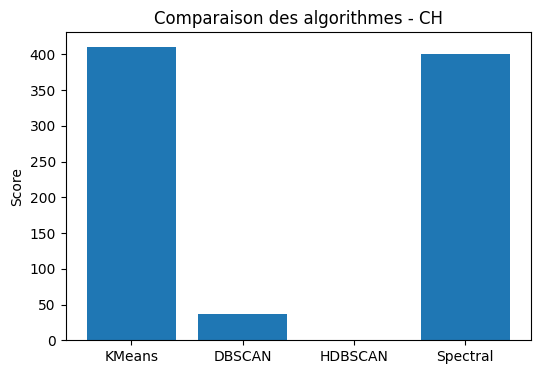

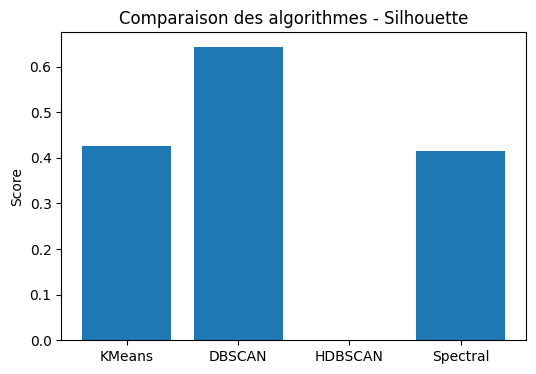

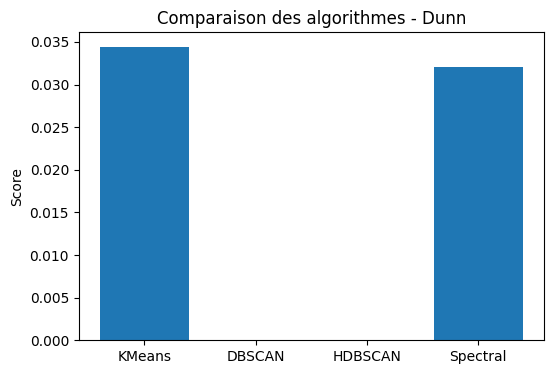

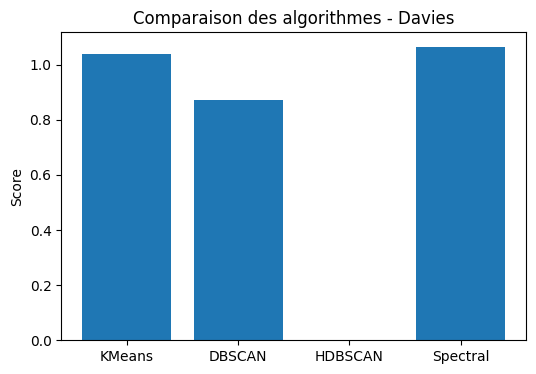

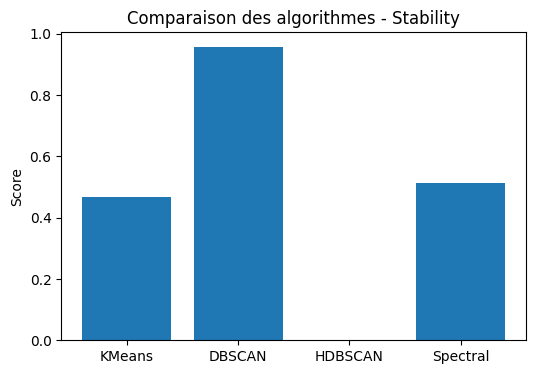

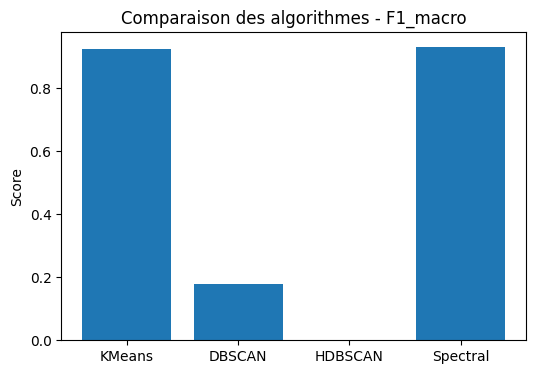

 Le meilleur algorithme est : KMeans


In [12]:
best, labels, results = clustering_compare_full(X,y, k=2, eps=6.714046275145607, minPts=75, pca_components=4)

Conclusion :

K-means est le meilleur algorithme dans cette situation :

Score Calinski-Harabasz (CH) très élevé (≈400) : nettement supérieur aux autres, indiquant une excellente séparation entre les clusters

Score Silhouette le plus haut (≈0.55) : meilleure cohérence interne des clusters

Indice Davies-Bouldin faible : bonne séparation et compacité

Score Dunn correct : performance moyenne mais compétitive

Stabilité correcte : comparable aux autres méthodes

HDBSCAN montrent des performances médiocres :

Scores très bas sur toutes les métriques (Silhouette ≈0.1, CH ≈50)

Probablement incapables de détecter une structure clusterisée efficacement. 


Par contre DBSCAN a été très compétitif. avec un score F1  élevé par rapport au autres, mais une indice CH faible (mauvaise séparation) , une indice de DB plus faible, et  une indice de dunn quasiment null. 

Spectral Clustering obtient des résultats moyens mais inférieurs à K-means.



Choix : K-means avec k=2 (confirmé par les analyses précédentes) est la méthode optimale pour ce jeu de données.

## II. Aplication du meilleur algorithme de clustering 

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

def kmeans_visual(df, k=2, sample_size=2000, pca_components=2,show_graphic=True, random_state=42):
 

    # Standardisation 
    X = StandardScaler().fit_transform(df)

    # Entraînement du modèle
    kmeans = KMeans(n_clusters=k, random_state=random_state, n_init='auto')
    labels = kmeans.fit_predict(X)

    #  Échantillonnage pour affichage
    n = len(X)
    if n > sample_size:
        idx = np.random.choice(n, sample_size, replace=False)
        X_sample = X[idx]
        labels_sample = labels[idx]
    else:
        X_sample = X
        labels_sample = labels

    # Réduction PCA pour visualisation
    if X_sample.shape[1] > pca_components:
        X_visu = PCA(n_components=pca_components, random_state=random_state).fit_transform(X_sample)
    else:
        X_visu = X_sample


    if show_graphic:
      #Visualisation
      plt.figure(figsize=(7,6))
      scatter = plt.scatter(
          X_visu[:,0], X_visu[:,1],
          c=labels_sample, cmap='tab10', s=10, alpha=0.7
      )
      plt.title(f"K-Means (k={k}) sur {len(X_sample)} points")
      plt.xlabel("Composante 1 (PCA)" if pca_components >= 2 else "Feature 1")
      plt.ylabel("Composante 2 (PCA)" if pca_components >= 2 else "Feature 2")
      plt.colorbar(scatter, label="Cluster")
      plt.show()

    # ----  Retour ----
    return labels, kmeans


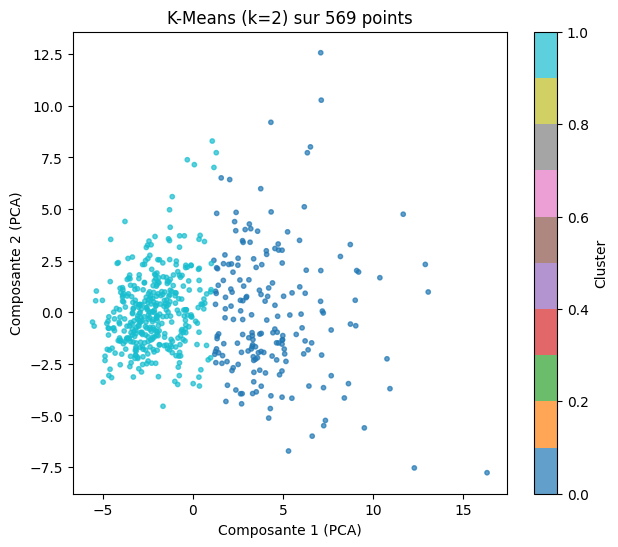

In [ ]:
labels, model = kmeans_visual(X,y, k=2, sample_size=569)

In [89]:
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,

Nous pourrons utiliser les labels de clusters obtenus pour :
- Analyser la répartition des tumeurs bénignes vs malignes dans chaque cluster.
- Étudier les caractéristiques moyennes des cellules dans chaque cluster.
- l'ajouter comme nouvelle caractéristique pour améliorer la prédiction finale.